## SIFT(Scale Invariant Feature Transform)
- 크기(Scale), 회전(Rotation), 조명 변화에 강인한 특징점(keypoint)을 추출하는 알고리즘
- 이미지에서 눈에 띄는 지점(코너, 엣지 등)을 찾고, 해당 위치에서 128차원 디스크립터를 계산함
- 이미지 매칭, 객체 인식 등에서 사용됨
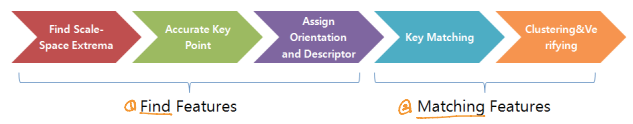
- SIFT는 영상에서 코너점 등 식별이 용이한 특징점들을 선택한 후에 각 특징점을 중심으로 한 로컬 패치(local patch)에 대해 아래 그림과 같은 특징 벡터를 추출한 것을 말함.
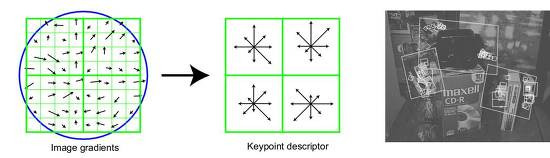
    - 1)특징점 주변의 영상패치를 4 x 4 블록으로 나누고 
    - 2)각 블록에 속한 픽셀들의 gradient 방향과 크기에 대한 히스토그램을 구한 후 이 히스토그램 bin 값들을 일렬로 쭉 연결한 128차원 벡터

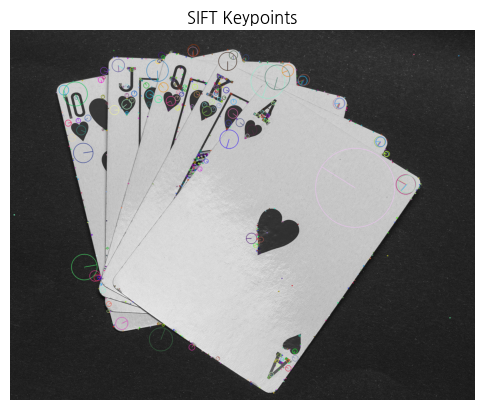

In [3]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('../cv_images/poker.jpg', 0)  # 그레이스케일 이미지
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(img, None)

img_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img_kp, cmap='gray')
plt.title("SIFT Keypoints")
plt.axis('off')
plt.show()


### 패턴 인식기 - 특정 로고나 패턴 검출

이미지에서 142개의 특징점 검출
템플릿에서 19개의 특징점 검출
좋은 매칭 수: 15


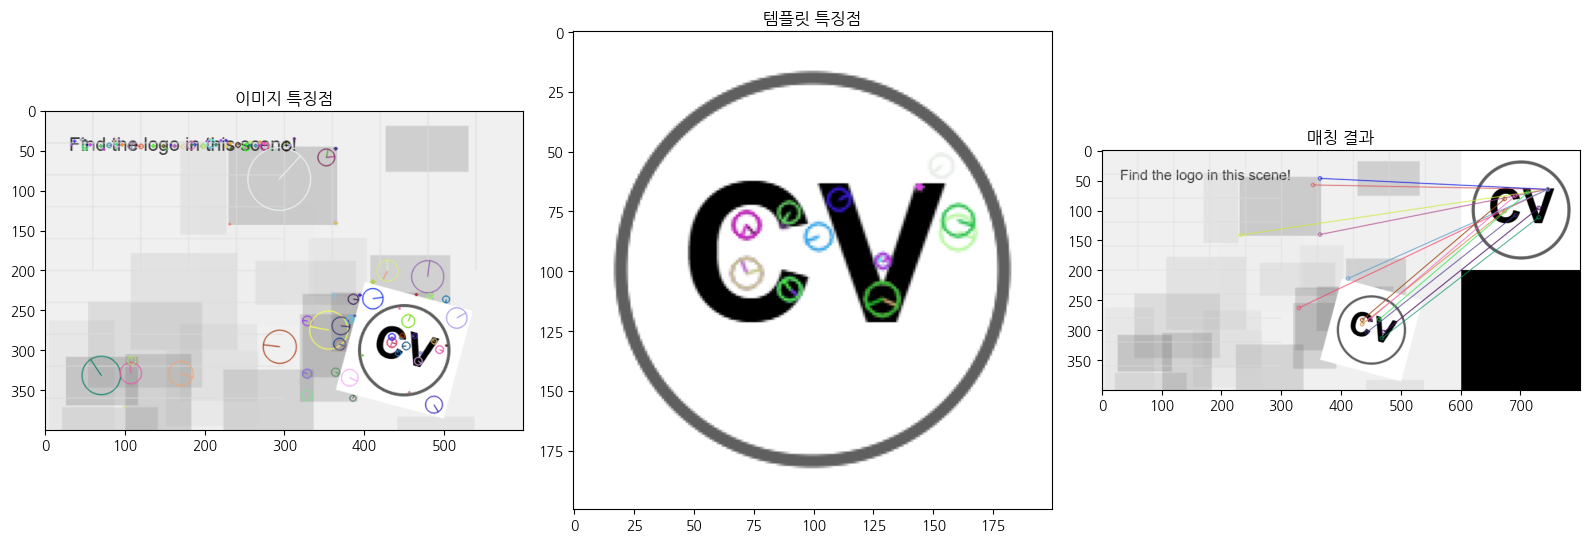

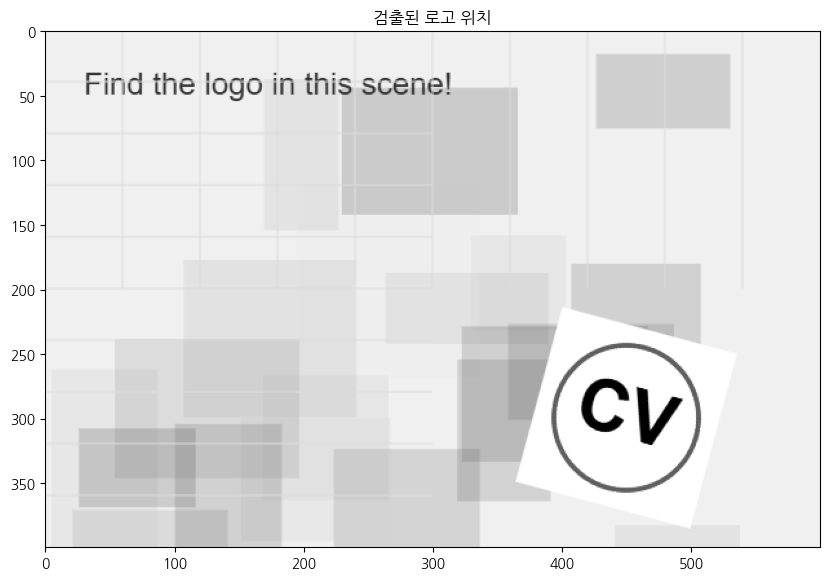

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 이미지와 템플릿(로고) 로드
img = cv2.imread('../cv_images/scene_with_logo.jpg', 0)  # 그레이스케일로 로드
template = cv2.imread('../cv_images/logo_template.jpg', 0)  # 찾을 로고 템플릿

# SIFT 특징점 추출
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img, None)
kp2, des2 = sift.detectAndCompute(template, None)

# 매칭
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# 좋은 매칭 선별
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# 결과 시각화
img_with_kp = cv2.drawKeypoints(img, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
template_with_kp = cv2.drawKeypoints(template, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print(f"이미지에서 {len(kp1)}개의 특징점 검출")
print(f"템플릿에서 {len(kp2)}개의 특징점 검출")
print(f"좋은 매칭 수: {len(good_matches)}")

# 매칭 결과 표시
match_img = cv2.drawMatches(img, kp1, template, kp2, good_matches, None, flags=2)

plt.figure(figsize=(16, 8))
plt.subplot(131), plt.imshow(img_with_kp, cmap='gray'), plt.title('이미지 특징점')
plt.subplot(132), plt.imshow(template_with_kp, cmap='gray'), plt.title('템플릿 특징점')
plt.subplot(133), plt.imshow(match_img), plt.title('매칭 결과')
plt.tight_layout()
plt.show()

# 로고 위치 찾기 (충분한 매칭이 있다면)
if len(good_matches) > 10:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    h, w = template.shape
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    
    # 원본 이미지에 로고 위치 표시
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    dst = cv2.perspectiveTransform(pts, M)
    color_img = cv2.polylines(color_img, [np.int32(dst)], True, (0, 255, 0), 3)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
    plt.title('검출된 로고 위치')
    plt.show()